In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFromModel

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# **Read Data:**

In [ ]:
# Connect google drive account

#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/T5_Camp/"
file_name = "cleaned_records.csv"
cleaned_records = pd.read_csv(path + file_name)

In [ ]:
cleaned_records.head(3)

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,show,appointment_time,sameday,sameweek,samemonth
0,29872499824296,0,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1,0,1,1,1
1,558997776694438,1,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1,0,1,1,1
2,4262962299951,0,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,1,0,1,1,1


---
# **Classification Build & Testing:**

## Setup Training & Testing Sets:

In [ ]:
class OurFeaturesSelection():
  def __init__(self, x_train, y_train) -> None:
    self.x_train = x_train
    self.selection = SelectFromModel(RandomForestClassifier(n_estimators=100))
    self.selection.fit(x_train, y_train)

  def get_selected_features(self):
    return self.x_train.columns[self.selection.get_support()]

  def plot_selected_features(self, figsize=(16,8), color='green'):
    x_axis = pd.Series(self.selection.estimator_.feature_importances_.ravel())
    y_axis = pd.Series(self.x_train.columns)

    plt.figure(figsize=figsize)
    return sns.barplot(x=y_axis, y=x_axis, color=color);
  
  def get_importance(self):
    return self.selection.estimator_.feature_importances_

In [ ]:
X = cleaned_records[['Gender', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'appointment_time', 'sameday']]
y = cleaned_records['show']

In [ ]:
cv = 5
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

selection = OurFeaturesSelection(x_train, y_train)
x_train_selected =  x_train[selection.get_selected_features()]

In [ ]:
x_train_selected

,Age,appointment_time
48329,6,29
58752,2,28
100213,71,42
18328,30,0
6850,59,2
...,...,...
85861,49,15
7242,31,21
70702,55,13
63251,55,0


In [ ]:
selection.get_importance()

array([0.01523972, 0.42030266, 0.00755944, 0.00971518, 0.00786767,
       0.00633242, 0.008524  , 0.01633997, 0.44181541, 0.06630353])

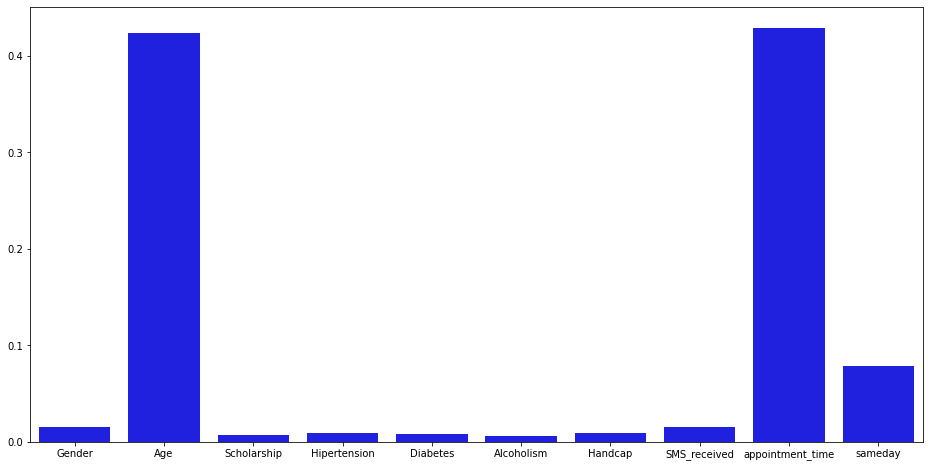

In [ ]:
selection.plot_selected_features(color='blue');

In [ ]:
cv = 5
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

selection = OurFeaturesSelection(x_train, y_train)
x_train_selected =  x_train[selection.get_selected_features()]
x_test_selected =  x_test[selection.get_selected_features()]

scaler = StandardScaler()

x_train_selected_scaled = scaler.fit_transform(x_train_selected.values)
x_test_selected_scaled = scaler.transform(x_test_selected.values)

In [ ]:
smote_tomek = SMOTETomek()
x_resamp_selected, y_resamp = smote_tomek.fit_resample(x_train_selected, y_train)

x_resamp_selected_scaled = scaler.fit_transform(x_resamp_selected.values)

In [ ]:
smote = SMOTE()
x_over_selected, y_over = smote.fit_resample(x_train_selected, y_train)
x_over_selected_scaled = scaler.fit_transform(x_over_selected.values)

- x_train: all train features
- x_test: all test features
- x_train_selected: selected train features
- x_test_selected: selected test features
- x_train_selected_scaled: selected train features scaled
- x_test_selected_scaled: selected test features scaled
---
- y_train: train target
- y_test: test target
---
- x_resamp_selected: (oversample+undersample) selected train features
- x_resamp_selected_scaled: (oversample+undersample) selected train features scaled
- y_resamp: (oversample+undersample) selected train target
- x_over_selected: (oversample) selected train features
- x_over_selected_scaled: (oversample) selected train features scaled
- y_over: (oversample) selected train target


## Define Modieling Functions:

In [ ]:
def evaluate_model(model, x_test, y_test, label, plot_wait_time=1):
  plt.show(block=False)

  y_pred = model.predict(x_test)

  print("***********************************************************************")
  print("#" + label + ":")
  print("--------------------------------------------------")

  print("\tAccuracy Score: " + str(accuracy_score(y_test, y_pred)) + '\n\n')
  print(classification_report(y_test, y_pred))
  print("--------------------------------------------------")
  print("Confusion Matrix:")
  grid_confusion_matrix = confusion_matrix(y_test, y_pred)
  grid_display = ConfusionMatrixDisplay(confusion_matrix=grid_confusion_matrix)
  grid_display.plot()
  plt.pause(plot_wait_time)
  plt.close()
  print("***********************************************************************\n\n")


def evaluation_result(search_algorithm, x_test, y_test, label, plot_wait_time=1):
  plt.show(block=False)

  print("***********************************************************************")
  print("#" + label + ":")
  print("--------------------------------------------------")
  print ("\tBest Score: ",str(search_algorithm.best_score_))
  print ("\tBest Parameters: ",str(search_algorithm.best_params_))
  print ("\tBest Estimators: ",str(search_algorithm.best_estimator_))

  y_pred = search_algorithm.predict(x_test)

  print("\tAccuracy Score: " + str(accuracy_score(y_test, y_pred)) + '\n\n')
  print(classification_report(y_test, y_pred))
  print("--------------------------------------------------")
  print("Confusion Matrix:")
  grid_confusion_matrix = confusion_matrix(y_test, y_pred)
  grid_display = ConfusionMatrixDisplay(confusion_matrix=grid_confusion_matrix)
  grid_display.plot()
  plt.pause(plot_wait_time)
  plt.close()
  print("***********************************************************************\n\n")



def modeling(model, x_train, x_test, y_train, y_test, hyper_params, model_label, cv=5,
             scoring='accuracy', random_state=5, verbose=3, n_jobs=-1, show_results=False):
  
  grid = GridSearchCV(estimator=model, param_grid=hyper_params, scoring=scoring, verbose=verbose, n_jobs=n_jobs, cv=cv)
  grid.fit(x_train, y_train)
  if show_results:
    evaluation_result(grid, x_test, y_test, model_label + " Grid Search")
  
  rand = RandomizedSearchCV(estimator=model, param_distributions=hyper_params, scoring=scoring,
                            verbose=verbose, n_jobs=n_jobs, cv=cv, random_state=random_state)
  rand.fit(x_train, y_train)
  if show_results:
    evaluation_result(rand, x_test, y_test, model_label + " Random Search")

  return grid, rand



In [ ]:
def knn_model(x_train, x_test, y_train, y_test, cv=5, show_results=False):
  hyper_params = {
    'n_neighbors': list(range(1,16)),
    'weights': ['uniform','distance']
    }

  return modeling(KNeighborsClassifier(), x_train, x_test, y_train, y_test, hyper_params, "KNN", cv=cv, show_results=show_results)

In [ ]:
def logistic_model(x_train, x_test, y_train, y_test, cv=5, show_results=False):
  hyper_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.5, 0.6, 0.7, 0.8],
    'solver': ['liblinear', 'saga']
    }

  return modeling(LogisticRegression(), x_train, x_test, y_train, y_test, hyper_params, "Logistic", cv=cv, show_results=show_results)

In [ ]:
def decision_tree_model(x_train, x_test, y_train, y_test, cv=5, show_results=False):
  hyper_params = {
    'max_depth': [2, 3, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ["gini", "entropy"]
    }

  tree_model = DecisionTreeClassifier()
  return modeling(tree_model, x_train, x_test, y_train, y_test, hyper_params, "Decision Tree", cv=cv, show_results=show_results)

In [ ]:
def random_forest_model(x_train, x_test, y_train, y_test, cv=5, show_results=False):
  hyper_params = {
    'max_depth': [4, 7],
    'max_features': ['auto', 'sqrt', 'log2'],
    "n_estimators": [10, 20, 30],
    "criterion" : ["gini", "entropy"]
    }

  rf_model = RandomForestClassifier(random_state=71)
  return modeling(rf_model, x_train, x_test, y_train, y_test, hyper_params, "Random Forest", cv=cv, show_results=show_results)

In [ ]:
def svm_model(x_train, x_test, y_train, y_test, cv=5, show_results=False):
  hyper_params = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1],
    'gamma': [0.01, 0.1, 1]
    }
  hyper_params = {}

  return modeling(SVC(), x_train, x_test, y_train, y_test, hyper_params, "SVM", cv=cv, show_results=show_results)

In [ ]:
def xgboost_model(x_train, x_test, y_train, y_test, cv=5, show_results=False):
  hyper_params = {
    'n_estimators': range(60, 90, 40),
    'max_depth': range(2, 10, 1),
    "learning_rate": [0.1, 0.01, 0.05]
    }

  xgb_model = xgb.XGBClassifier()
  return modeling(xgb_model, x_train, x_test, y_train, y_test, hyper_params, "XGBoost", cv=cv, show_results=show_results)

In [ ]:
def results_as_series(search_algorithm, x_test, y_test, indexes):
  y_pred = search_algorithm.predict(x_test)

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  best_params = search_algorithm.best_params_
  confusion_mat = confusion_matrix(y_test, y_pred)

  return pd.Series([accuracy, precision, recall, best_params, confusion_mat], index=indexes)

def results_as_dataframe(x_test, y_test, models):
  indexes = ['accuracy', 'precision', 'recall', 'best_params', 'confusion_matrix']
  results = pd.DataFrame(index=indexes)

  for model in models:
    grid, rand = models[model]

    grid_series = results_as_series(grid, x_test, y_test, indexes)
    rand_series = results_as_series(rand, x_test, y_test, indexes)

    results[model + "_grid"] = grid_series
    results[model + "_random"] = rand_series

  return results.T

In [ ]:
import time

class Cal_Time():
  def __init__(self):
    self.start_time = time.process_time()

  def cal(self):
    end_time = time.process_time()
    diff_time = end_time - self.start_time
    return "Execution Time: " + str(diff_time)


## Output Functions:

In [ ]:
def get_best_model(search_algorithm):
  estimator = search_algorithm.estimator
  estimator.set_params(**search_algorithm.best_params_)
  return estimator


def stacking(x_train, x_test, y_train, y_test, models, show_results=False):
  stacking = StackingClassifier(estimators=models, final_estimator=LogisticRegression())
  stacking.fit(x_train, y_train)

  if show_results:
    evaluate_model(stacking, x_test, y_test, "Stacking")
  
  return stacking


In [ ]:
def fit_all(x_train, x_train_scaled, x_test, x_test_scaled, y_train, y_test, cv=5,
            knn=True, logistics=True, tree=True, rf=True, svm=True, xgb=True, pre_label='', post_label='', show_results=False):
  results_dict = {}
  grid_label = ' Grid'
  rand_label = ' Random'

  if knn:
    knn_grid, knn_rand = knn_model(x_train_scaled, x_test_scaled, y_train, y_test, cv=cv, show_results=show_results);
    name = 'KNN'
    results_dict[pre_label+name+grid_label+post_label] = knn_grid
    results_dict[pre_label+name+rand_label+post_label] = knn_rand
  if logistics:
    log_grid, log_rand = logistic_model(x_train_scaled, x_test_scaled, y_train, y_test, cv=cv, show_results=show_results);
    name = 'Logistic'
    results_dict[pre_label+name+grid_label+post_label] = log_grid
    results_dict[pre_label+name+rand_label+post_label] = log_rand
  if tree:
    tree_grid, tree_rand = decision_tree_model(x_train, x_test, y_train, y_test, cv=cv, show_results=show_results);
    name = 'Decision Tree'
    results_dict[pre_label+name+grid_label+post_label] = tree_grid
    results_dict[pre_label+name+rand_label+post_label] = tree_rand
  if rf:
    rf_grid, rf_rand = random_forest_model(x_train, x_test, y_train, y_test, cv=cv, show_results=show_results);
    name = 'Random Forest'
    results_dict[pre_label+name+grid_label+post_label] = rf_grid
    results_dict[pre_label+name+rand_label+post_label] = rf_rand
  if svm:
    svm_grid, svm_rand = svm_model(x_train_scaled, x_test_scaled, y_train, y_test, cv=cv, show_results=show_results);
    name = 'SVM'
    results_dict[pre_label+name+grid_label+post_label] = svm_grid
    results_dict[pre_label+name+rand_label+post_label] = svm_rand
  if xgb:
    xgb_grid, xgb_rand = xgboost_model(x_train, x_test, y_train, y_test, cv=cv, show_results=show_results);
    name = 'XGBoost'
    results_dict[pre_label+name+grid_label+post_label] = xgb_grid
    results_dict[pre_label+name+rand_label+post_label] = xgb_rand

  models = [('KNN', get_best_model(knn_grid)),
          ('Logistics', get_best_model(log_grid)),
          ('Tree', get_best_model(tree_grid)),
          ('Random Forest', get_best_model(rf_grid)),
          #('SVM', get_best_model(svm_grid)),
          ('XGBoost', get_best_model(xgb_grid))]

  name = 'Stacking'
  results_dict[pre_label+name+post_label] = stacking(x_train, x_test, y_train, y_test, models, show_results=show_results) 
  return results_dict



---
# **Classification Predictions:**

### Imbalance:

Fitting 5 folds for each of 30 candidates, totalling 150 fits
***********************************************************************
#KNN Grid Search:
--------------------------------------------------
	Best Score:  0.786463996623642
	Best Parameters:  {'n_neighbors': 15, 'weights': 'uniform'}
	Best Estimators:  KNeighborsClassifier(n_neighbors=15)
	Accuracy Score: 0.781180728342004


              precision    recall  f1-score   support

           0       0.33      0.08      0.12      4477
           1       0.80      0.96      0.87     17628

    accuracy                           0.78     22105
   macro avg       0.57      0.52      0.50     22105
weighted avg       0.71      0.78      0.72     22105

--------------------------------------------------
Confusion Matrix:


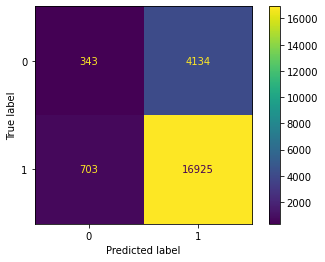

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#KNN Random Search:
--------------------------------------------------
	Best Score:  0.7779474368673478
	Best Parameters:  {'weights': 'uniform', 'n_neighbors': 14}
	Best Estimators:  KNeighborsClassifier(n_neighbors=14)
	Accuracy Score: 0.7748020809771545


              precision    recall  f1-score   support

           0       0.34      0.11      0.17      4477
           1       0.81      0.94      0.87     17628

    accuracy                           0.77     22105
   macro avg       0.57      0.53      0.52     22105
weighted avg       0.71      0.77      0.73     22105

--------------------------------------------------
Confusion Matrix:


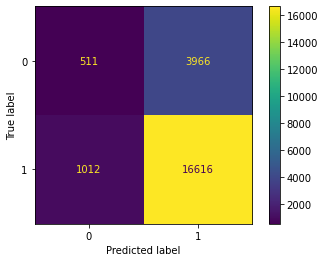

***********************************************************************


Fitting 5 folds for each of 16 candidates, totalling 80 fits
***********************************************************************
#Logistic Grid Search:
--------------------------------------------------
	Best Score:  0.7938608381544833
	Best Parameters:  {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
	Best Estimators:  LogisticRegression(C=0.5, penalty='l1', solver='liblinear')
	Accuracy Score: 0.793033250395838


              precision    recall  f1-score   support

           0       0.33      0.02      0.04      4477
           1       0.80      0.99      0.88     17628

    accuracy                           0.79     22105
   macro avg       0.56      0.51      0.46     22105
weighted avg       0.70      0.79      0.71     22105

--------------------------------------------------
Confusion Matrix:


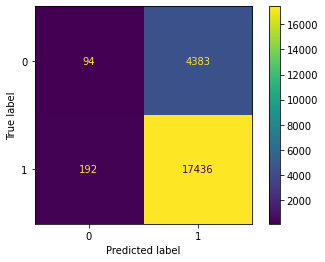

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#Logistic Random Search:
--------------------------------------------------
	Best Score:  0.7938608381544833
	Best Parameters:  {'solver': 'saga', 'penalty': 'l1', 'C': 0.6}
	Best Estimators:  LogisticRegression(C=0.6, penalty='l1', solver='saga')
	Accuracy Score: 0.793033250395838


              precision    recall  f1-score   support

           0       0.33      0.02      0.04      4477
           1       0.80      0.99      0.88     17628

    accuracy                           0.79     22105
   macro avg       0.56      0.51      0.46     22105
weighted avg       0.70      0.79      0.71     22105

--------------------------------------------------
Confusion Matrix:


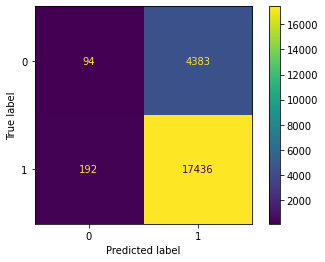

***********************************************************************


Fitting 5 folds for each of 24 candidates, totalling 120 fits
***********************************************************************
#Decision Tree Grid Search:
--------------------------------------------------
	Best Score:  0.7982604961183817
	Best Parameters:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto'}
	Best Estimators:  DecisionTreeClassifier(max_depth=2, max_features='auto')
	Accuracy Score: 0.7974666365075774


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4477
           1       0.80      1.00      0.89     17628

    accuracy                           0.80     22105
   macro avg       0.40      0.50      0.44     22105
weighted avg       0.64      0.80      0.71     22105

--------------------------------------------------
Confusion Matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



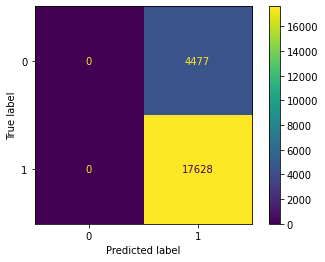

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#Decision Tree Random Search:
--------------------------------------------------
	Best Score:  0.7982604961183817
	Best Parameters:  {'max_features': 'log2', 'max_depth': 2, 'criterion': 'gini'}
	Best Estimators:  DecisionTreeClassifier(max_depth=2, max_features='log2')
	Accuracy Score: 0.7974666365075774


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4477
           1       0.80      1.00      0.89     17628

    accuracy                           0.80     22105
   macro avg       0.40      0.50      0.44     22105
weighted avg       0.64      0.80      0.71     22105

--------------------------------------------------
Confusion Matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



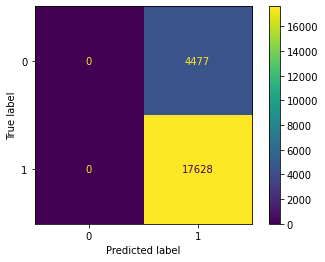

***********************************************************************


Fitting 5 folds for each of 36 candidates, totalling 180 fits
***********************************************************************
#Random Forest Grid Search:
--------------------------------------------------
	Best Score:  0.7982604961183817
	Best Parameters:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 10}
	Best Estimators:  RandomForestClassifier(max_depth=4, n_estimators=10, random_state=71)
	Accuracy Score: 0.7974666365075774


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4477
           1       0.80      1.00      0.89     17628

    accuracy                           0.80     22105
   macro avg       0.40      0.50      0.44     22105
weighted avg       0.64      0.80      0.71     22105

--------------------------------------------------
Confusion Matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



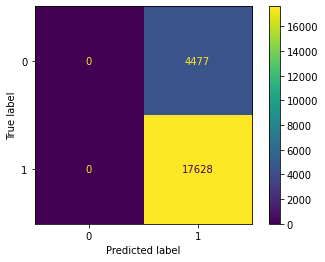

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#Random Forest Random Search:
--------------------------------------------------
	Best Score:  0.7982604961183817
	Best Parameters:  {'n_estimators': 20, 'max_features': 'sqrt', 'max_depth': 7, 'criterion': 'entropy'}
	Best Estimators:  RandomForestClassifier(criterion='entropy', max_depth=7, max_features='sqrt',
                       n_estimators=20, random_state=71)
	Accuracy Score: 0.7974666365075774


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4477
           1       0.80      1.00      0.89     17628

    accuracy                           0.80     22105
   macro avg       0.40      0.50      0.44     22105
weighted avg       0.64      0.80      0.71     22105

--------------------------------------------------
Confu

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



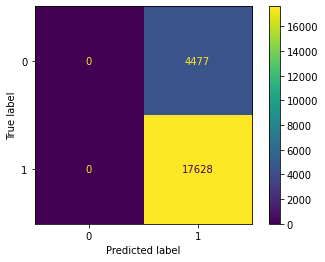

***********************************************************************


Fitting 5 folds for each of 24 candidates, totalling 120 fits
***********************************************************************
#XGBoost Grid Search:
--------------------------------------------------
	Best Score:  0.7983170469689356
	Best Parameters:  {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 60}
	Best Estimators:  XGBClassifier(learning_rate=0.05, max_depth=7, n_estimators=60)
	Accuracy Score: 0.7972404433386112


              precision    recall  f1-score   support

           0       0.33      0.00      0.00      4477
           1       0.80      1.00      0.89     17628

    accuracy                           0.80     22105
   macro avg       0.57      0.50      0.44     22105
weighted avg       0.70      0.80      0.71     22105

--------------------------------------------------
Confusion Matrix:


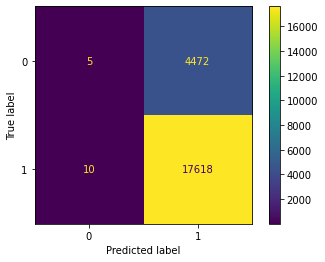

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#XGBoost Random Search:
--------------------------------------------------
	Best Score:  0.798271806416408
	Best Parameters:  {'n_estimators': 60, 'max_depth': 5, 'learning_rate': 0.05}
	Best Estimators:  XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=60)
	Accuracy Score: 0.7974666365075774


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4477
           1       0.80      1.00      0.89     17628

    accuracy                           0.80     22105
   macro avg       0.40      0.50      0.44     22105
weighted avg       0.64      0.80      0.71     22105

--------------------------------------------------
Confusion Matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



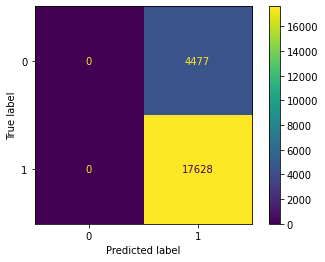

***********************************************************************


***********************************************************************
#Stacking:
--------------------------------------------------
	Accuracy Score: 0.7974213978737842


              precision    recall  f1-score   support

           0       0.43      0.00      0.00      4477
           1       0.80      1.00      0.89     17628

    accuracy                           0.80     22105
   macro avg       0.61      0.50      0.44     22105
weighted avg       0.72      0.80      0.71     22105

--------------------------------------------------
Confusion Matrix:


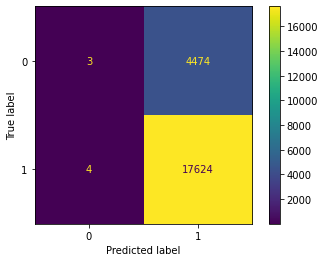

***********************************************************************




In [ ]:
results_imbalance = fit_all(x_train_selected, x_train_selected_scaled,
                  x_test_selected, x_test_selected_scaled,
                  y_train, y_test,
                  svm=False, show_results=True)

### SMOTE:

In [ ]:
len(x_over_selected_scaled)

88416

Fitting 5 folds for each of 30 candidates, totalling 150 fits
***********************************************************************
#KNN Grid Search:
--------------------------------------------------
	Best Score:  0.6324473668581209
	Best Parameters:  {'n_neighbors': 14, 'weights': 'distance'}
	Best Estimators:  KNeighborsClassifier(n_neighbors=14, weights='distance')
	Accuracy Score: 0.6097263062655508


              precision    recall  f1-score   support

           0       0.26      0.50      0.34      4477
           1       0.83      0.64      0.72     17628

    accuracy                           0.61     22105
   macro avg       0.55      0.57      0.53     22105
weighted avg       0.72      0.61      0.65     22105

--------------------------------------------------
Confusion Matrix:


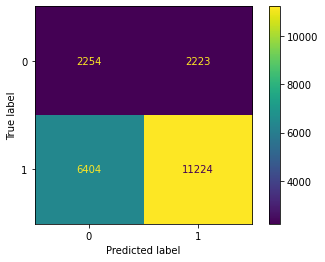

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#KNN Random Search:
--------------------------------------------------
	Best Score:  0.627190826673748
	Best Parameters:  {'weights': 'uniform', 'n_neighbors': 14}
	Best Estimators:  KNeighborsClassifier(n_neighbors=14)
	Accuracy Score: 0.6014928749151776


              precision    recall  f1-score   support

           0       0.26      0.53      0.35      4477
           1       0.84      0.62      0.71     17628

    accuracy                           0.60     22105
   macro avg       0.55      0.58      0.53     22105
weighted avg       0.72      0.60      0.64     22105

--------------------------------------------------
Confusion Matrix:


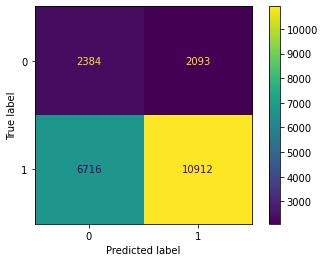

***********************************************************************


Fitting 5 folds for each of 16 candidates, totalling 80 fits
***********************************************************************
#Logistic Grid Search:
--------------------------------------------------
	Best Score:  0.6217784409958168
	Best Parameters:  {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
	Best Estimators:  LogisticRegression(C=0.5, penalty='l1', solver='liblinear')
	Accuracy Score: 0.675322325265777


              precision    recall  f1-score   support

           0       0.33      0.57      0.41      4477
           1       0.86      0.70      0.78     17628

    accuracy                           0.68     22105
   macro avg       0.60      0.63      0.59     22105
weighted avg       0.76      0.68      0.70     22105

--------------------------------------------------
Confusion Matrix:


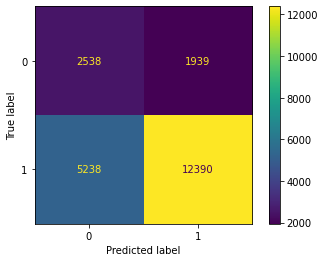

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#Logistic Random Search:
--------------------------------------------------
	Best Score:  0.6218067776350914
	Best Parameters:  {'solver': 'saga', 'penalty': 'l1', 'C': 0.5}
	Best Estimators:  LogisticRegression(C=0.5, penalty='l1', solver='saga')
	Accuracy Score: 0.675322325265777


              precision    recall  f1-score   support

           0       0.33      0.57      0.41      4477
           1       0.86      0.70      0.78     17628

    accuracy                           0.68     22105
   macro avg       0.60      0.63      0.59     22105
weighted avg       0.76      0.68      0.70     22105

--------------------------------------------------
Confusion Matrix:


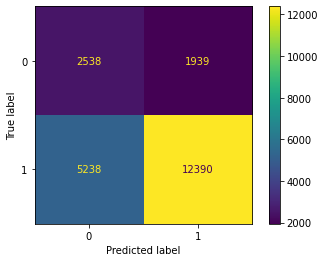

***********************************************************************


Fitting 5 folds for each of 24 candidates, totalling 120 fits
***********************************************************************
#Decision Tree Grid Search:
--------------------------------------------------
	Best Score:  0.6761785042255378
	Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2'}
	Best Estimators:  DecisionTreeClassifier(max_depth=10, max_features='log2')
	Accuracy Score: 0.5862022166930558


              precision    recall  f1-score   support

           0       0.30      0.79      0.44      4477
           1       0.91      0.53      0.67     17628

    accuracy                           0.59     22105
   macro avg       0.61      0.66      0.56     22105
weighted avg       0.79      0.59      0.63     22105

--------------------------------------------------
Confusion Matrix:


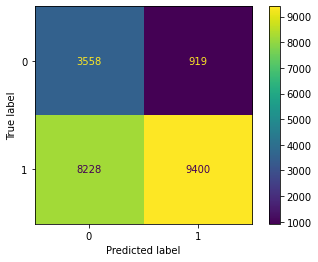

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#Decision Tree Random Search:
--------------------------------------------------
	Best Score:  0.6752008615639189
	Best Parameters:  {'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}
	Best Estimators:  DecisionTreeClassifier(max_depth=10, max_features='sqrt')
	Accuracy Score: 0.5890974892558245


              precision    recall  f1-score   support

           0       0.30      0.78      0.43      4477
           1       0.91      0.54      0.68     17628

    accuracy                           0.59     22105
   macro avg       0.60      0.66      0.56     22105
weighted avg       0.78      0.59      0.63     22105

--------------------------------------------------
Confusion Matrix:


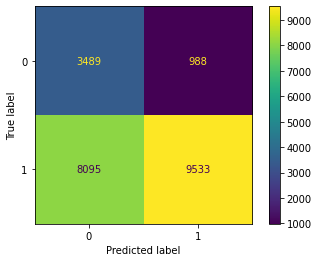

***********************************************************************


Fitting 5 folds for each of 36 candidates, totalling 180 fits
***********************************************************************
#Random Forest Grid Search:
--------------------------------------------------
	Best Score:  0.6744640943885214
	Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 20}
	Best Estimators:  RandomForestClassifier(max_depth=7, n_estimators=20, random_state=71)
	Accuracy Score: 0.5781497398778557


              precision    recall  f1-score   support

           0       0.30      0.83      0.44      4477
           1       0.92      0.51      0.66     17628

    accuracy                           0.58     22105
   macro avg       0.61      0.67      0.55     22105
weighted avg       0.80      0.58      0.62     22105

--------------------------------------------------
Confusion Matrix:


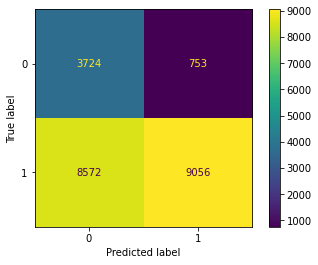

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#Random Forest Random Search:
--------------------------------------------------
	Best Score:  0.6744640943885214
	Best Parameters:  {'n_estimators': 20, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'gini'}
	Best Estimators:  RandomForestClassifier(max_depth=7, n_estimators=20, random_state=71)
	Accuracy Score: 0.5781497398778557


              precision    recall  f1-score   support

           0       0.30      0.83      0.44      4477
           1       0.92      0.51      0.66     17628

    accuracy                           0.58     22105
   macro avg       0.61      0.67      0.55     22105
weighted avg       0.80      0.58      0.62     22105

--------------------------------------------------
Confusion Matrix:


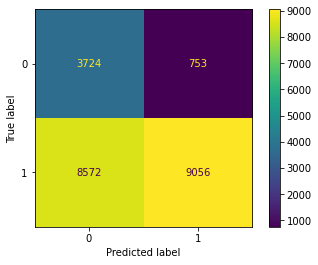

***********************************************************************


Fitting 5 folds for each of 24 candidates, totalling 120 fits
***********************************************************************
#XGBoost Grid Search:
--------------------------------------------------
	Best Score:  0.6869820012705568
	Best Parameters:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 60}
	Best Estimators:  XGBClassifier(max_depth=9, n_estimators=60)
	Accuracy Score: 0.5915856141144538


              precision    recall  f1-score   support

           0       0.30      0.79      0.44      4477
           1       0.91      0.54      0.68     17628

    accuracy                           0.59     22105
   macro avg       0.61      0.67      0.56     22105
weighted avg       0.79      0.59      0.63     22105

--------------------------------------------------
Confusion Matrix:


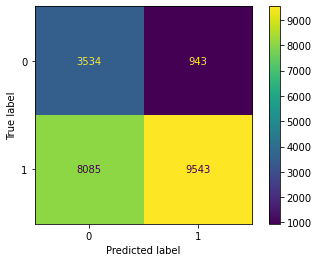

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#XGBoost Random Search:
--------------------------------------------------
	Best Score:  0.6823984901452465
	Best Parameters:  {'n_estimators': 60, 'max_depth': 9, 'learning_rate': 0.05}
	Best Estimators:  XGBClassifier(learning_rate=0.05, max_depth=9, n_estimators=60)
	Accuracy Score: 0.5890522506220313


              precision    recall  f1-score   support

           0       0.30      0.79      0.44      4477
           1       0.91      0.54      0.68     17628

    accuracy                           0.59     22105
   macro avg       0.61      0.66      0.56     22105
weighted avg       0.79      0.59      0.63     22105

--------------------------------------------------
Confusion Matrix:


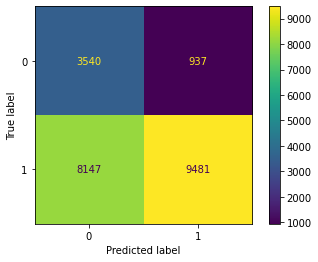

***********************************************************************


***********************************************************************
#Stacking:
--------------------------------------------------
	Accuracy Score: 0.6221216919249039


              precision    recall  f1-score   support

           0       0.31      0.71      0.43      4477
           1       0.89      0.60      0.72     17628

    accuracy                           0.62     22105
   macro avg       0.60      0.66      0.58     22105
weighted avg       0.77      0.62      0.66     22105

--------------------------------------------------
Confusion Matrix:


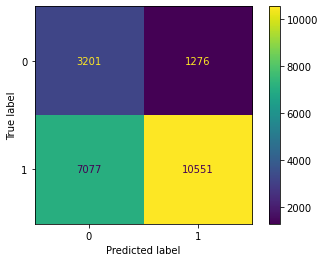

***********************************************************************




In [ ]:
results_smote = fit_all(x_over_selected, x_over_selected_scaled,
                  x_test_selected, x_test_selected_scaled,
                  y_over, y_test,
                  svm=False, show_results=True)

### SMOTE+TOMEK:

Fitting 5 folds for each of 30 candidates, totalling 150 fits
***********************************************************************
#KNN Grid Search:
--------------------------------------------------
	Best Score:  0.6301226167694379
	Best Parameters:  {'n_neighbors': 14, 'weights': 'distance'}
	Best Estimators:  KNeighborsClassifier(n_neighbors=14, weights='distance')
	Accuracy Score: 0.6040714770413933


              precision    recall  f1-score   support

           0       0.26      0.52      0.35      4477
           1       0.84      0.63      0.72     17628

    accuracy                           0.60     22105
   macro avg       0.55      0.57      0.53     22105
weighted avg       0.72      0.60      0.64     22105

--------------------------------------------------
Confusion Matrix:


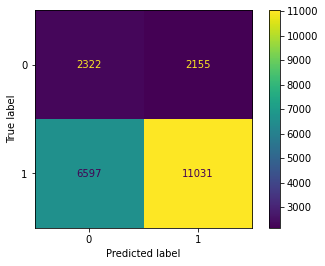

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#KNN Random Search:
--------------------------------------------------
	Best Score:  0.6269473385782124
	Best Parameters:  {'weights': 'distance', 'n_neighbors': 12}
	Best Estimators:  KNeighborsClassifier(n_neighbors=12, weights='distance')
	Accuracy Score: 0.597557113775164


              precision    recall  f1-score   support

           0       0.26      0.52      0.34      4477
           1       0.84      0.62      0.71     17628

    accuracy                           0.60     22105
   macro avg       0.55      0.57      0.53     22105
weighted avg       0.72      0.60      0.64     22105

--------------------------------------------------
Confusion Matrix:


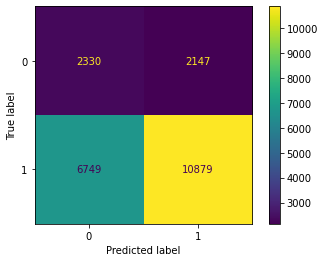

***********************************************************************


Fitting 5 folds for each of 16 candidates, totalling 80 fits
***********************************************************************
#Logistic Grid Search:
--------------------------------------------------
	Best Score:  0.620405414983344
	Best Parameters:  {'C': 0.8, 'penalty': 'l2', 'solver': 'saga'}
	Best Estimators:  LogisticRegression(C=0.8, solver='saga')
	Accuracy Score: 0.6749151775616377


              precision    recall  f1-score   support

           0       0.33      0.57      0.41      4477
           1       0.87      0.70      0.77     17628

    accuracy                           0.67     22105
   macro avg       0.60      0.64      0.59     22105
weighted avg       0.76      0.67      0.70     22105

--------------------------------------------------
Confusion Matrix:


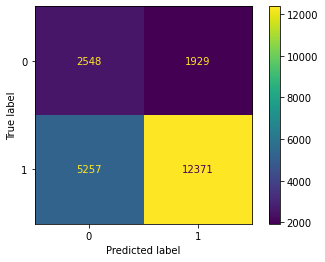

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#Logistic Random Search:
--------------------------------------------------
	Best Score:  0.62039832730881
	Best Parameters:  {'solver': 'saga', 'penalty': 'l1', 'C': 0.6}
	Best Estimators:  LogisticRegression(C=0.6, penalty='l1', solver='saga')
	Accuracy Score: 0.6749151775616377


              precision    recall  f1-score   support

           0       0.33      0.57      0.41      4477
           1       0.87      0.70      0.77     17628

    accuracy                           0.67     22105
   macro avg       0.60      0.64      0.59     22105
weighted avg       0.76      0.67      0.70     22105

--------------------------------------------------
Confusion Matrix:


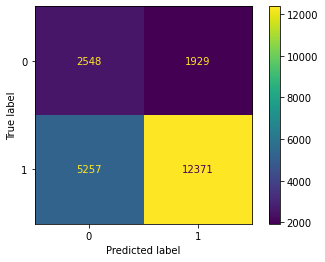

***********************************************************************


Fitting 5 folds for each of 24 candidates, totalling 120 fits
***********************************************************************
#Decision Tree Grid Search:
--------------------------------------------------
	Best Score:  0.675696364022964
	Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2'}
	Best Estimators:  DecisionTreeClassifier(max_depth=10, max_features='log2')
	Accuracy Score: 0.5926713413254919


              precision    recall  f1-score   support

           0       0.30      0.79      0.44      4477
           1       0.91      0.54      0.68     17628

    accuracy                           0.59     22105
   macro avg       0.61      0.66      0.56     22105
weighted avg       0.79      0.59      0.63     22105

--------------------------------------------------
Confusion Matrix:


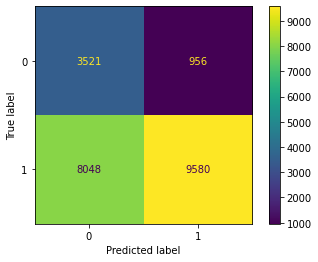

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#Decision Tree Random Search:
--------------------------------------------------
	Best Score:  0.6759727833297895
	Best Parameters:  {'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}
	Best Estimators:  DecisionTreeClassifier(max_depth=10, max_features='sqrt')
	Accuracy Score: 0.598597602352409


              precision    recall  f1-score   support

           0       0.31      0.78      0.44      4477
           1       0.91      0.55      0.69     17628

    accuracy                           0.60     22105
   macro avg       0.61      0.67      0.56     22105
weighted avg       0.79      0.60      0.64     22105

--------------------------------------------------
Confusion Matrix:


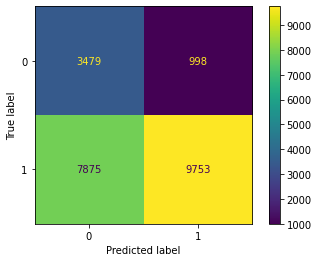

***********************************************************************


Fitting 5 folds for each of 36 candidates, totalling 180 fits
***********************************************************************
#Random Forest Grid Search:
--------------------------------------------------
	Best Score:  0.6741796016726912
	Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 20}
	Best Estimators:  RandomForestClassifier(max_depth=7, n_estimators=20, random_state=71)
	Accuracy Score: 0.5809545351730377


              precision    recall  f1-score   support

           0       0.30      0.82      0.44      4477
           1       0.92      0.52      0.66     17628

    accuracy                           0.58     22105
   macro avg       0.61      0.67      0.55     22105
weighted avg       0.80      0.58      0.62     22105

--------------------------------------------------
Confusion Matrix:


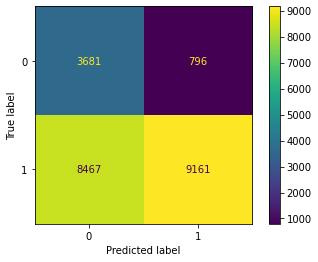

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#Random Forest Random Search:
--------------------------------------------------
	Best Score:  0.6741796016726912
	Best Parameters:  {'n_estimators': 20, 'max_features': 'auto', 'max_depth': 7, 'criterion': 'gini'}
	Best Estimators:  RandomForestClassifier(max_depth=7, n_estimators=20, random_state=71)
	Accuracy Score: 0.5809545351730377


              precision    recall  f1-score   support

           0       0.30      0.82      0.44      4477
           1       0.92      0.52      0.66     17628

    accuracy                           0.58     22105
   macro avg       0.61      0.67      0.55     22105
weighted avg       0.80      0.58      0.62     22105

--------------------------------------------------
Confusion Matrix:


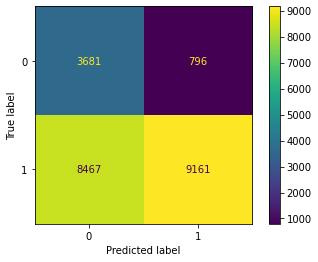

***********************************************************************


Fitting 5 folds for each of 24 candidates, totalling 120 fits
***********************************************************************
#XGBoost Grid Search:
--------------------------------------------------
	Best Score:  0.6861294209369906
	Best Parameters:  {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 60}
	Best Estimators:  XGBClassifier(max_depth=9, n_estimators=60)
	Accuracy Score: 0.5942546935082561


              precision    recall  f1-score   support

           0       0.31      0.79      0.44      4477
           1       0.91      0.55      0.68     17628

    accuracy                           0.59     22105
   macro avg       0.61      0.67      0.56     22105
weighted avg       0.79      0.59      0.63     22105

--------------------------------------------------
Confusion Matrix:


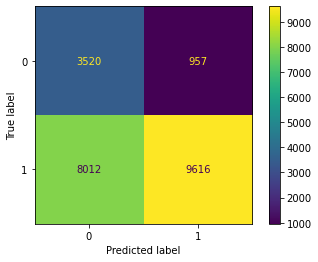

***********************************************************************


Fitting 5 folds for each of 10 candidates, totalling 50 fits
***********************************************************************
#XGBoost Random Search:
--------------------------------------------------
	Best Score:  0.6826635480898717
	Best Parameters:  {'n_estimators': 60, 'max_depth': 9, 'learning_rate': 0.05}
	Best Estimators:  XGBClassifier(learning_rate=0.05, max_depth=9, n_estimators=60)
	Accuracy Score: 0.5910427505089346


              precision    recall  f1-score   support

           0       0.30      0.79      0.44      4477
           1       0.91      0.54      0.68     17628

    accuracy                           0.59     22105
   macro avg       0.61      0.66      0.56     22105
weighted avg       0.79      0.59      0.63     22105

--------------------------------------------------
Confusion Matrix:


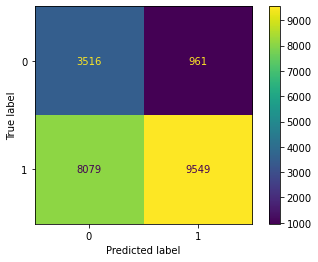

***********************************************************************


***********************************************************************
#Stacking:
--------------------------------------------------
	Accuracy Score: 0.6212169192490387


              precision    recall  f1-score   support

           0       0.31      0.71      0.43      4477
           1       0.89      0.60      0.72     17628

    accuracy                           0.62     22105
   macro avg       0.60      0.66      0.57     22105
weighted avg       0.77      0.62      0.66     22105

--------------------------------------------------
Confusion Matrix:


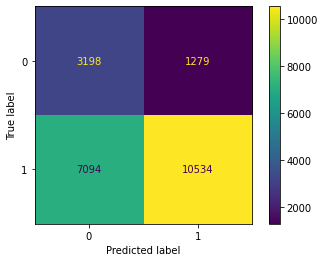

***********************************************************************




In [ ]:
results_smote_tomek = fit_all(x_resamp_selected, x_resamp_selected_scaled,
                  x_test_selected, x_test_selected_scaled,
                  y_resamp, y_test,
                  svm=False, show_results=True)

---
# **Best Model:**

***********************************************************************
--------------------------------------------------
	Accuracy Score: 0.5780140239764759


              precision    recall  f1-score   support

           0       0.30      0.83      0.44      4477
           1       0.92      0.51      0.66     17628

    accuracy                           0.58     22105
   macro avg       0.61      0.67      0.55     22105
weighted avg       0.80      0.58      0.62     22105

--------------------------------------------------
Confusion Matrix:


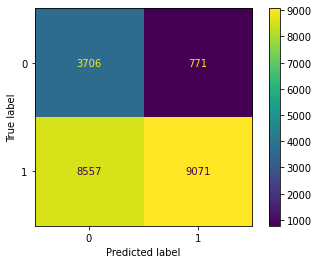

***********************************************************************


Precision Score: 0.9216622637675269
Recall Score: 0.5145790787383707
F1 Score: 0.6604295595194757


In [ ]:
rf = RandomForestClassifier(max_depth=7, n_estimators=20, random_state=71)
rf.fit(x_over_selected, y_over)

plt.show(block=False)

y_pred = rf.predict(x_test_selected)
print("***********************************************************************")
print("--------------------------------------------------")
print("\tAccuracy Score: " + str(accuracy_score(y_test, y_pred)) + '\n\n')
print(classification_report(y_test, y_pred))
print("--------------------------------------------------")
print("Confusion Matrix:")
rf_confusion_matrix = confusion_matrix(y_test, y_pred)
rf_display = ConfusionMatrixDisplay(confusion_matrix=grid_confusion_matrix)
rf_display.plot()
plt.pause(1)
plt.close()
print("***********************************************************************\n\n")
print("Precision Score: " + str(precision_score(y_test, y_pred)))
print("Recall Score: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))
